In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

import csv

In [2]:
# define class and function
class MultiLayerPerceptron(chainer.Chain):
    """Class of deep neural network(DNN) description
    
    Args:
        nodes(list of int):Nodes of network layers
        dropout(float):Dropout ratio
    """
    
    def __init__(self,nodes):
        super(MultiLayerPerceptron, self).__init__()
        self.nodes = nodes
        self.layers = len(self.nodes)
        for i in range(self.layers-1):
            self.add_link("l{}".format(i), L.Linear(self.nodes[i], self.nodes[i+1]))
            
    def __call__(self,x):
        """Return predictive values.
        
        Args:
            x([chainer]Variable):Input of DNN
        Returns:
            y([chainer]Variable):Output of DNN
        """
        y = self["l0"](x)
        for i in range(self.layers-2):
            h = F.relu(y)
            y = self["l{}".format(i+1)](h)
        return y
    
def train_test_tuple_dataset(x,y,test_ratio):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                        test_size = test_ratio,
                                                        random_state=True)
    print(y_test)
    print(type(y_test))
    train = chainer.datasets.TupleDataset(x_train, y_train)
    test = chainer.datasets.TupleDataset(x_test, y_test)
    return train,test

#高橋自作
def train_test_tuple_dataset2(x,y,test_data_size):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    #x_train, x_test, y_train, y_test = train_test_split(x,y,
    #                                                    test_size = test_ratio,
    #                                                    random_state=True)
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    i=0
    for i in range(len(x)-test_data_size):
        x_train.append(x[i])
        y_train.append(y[i])
    for i in range(test_data_size):
        x_test.append(x[len(x)-test_data_size+i])
        y_test.append(y[len(y)-test_data_size+i])
   
    train = chainer.datasets.TupleDataset(np.array(x_train), np.array(y_train))
    test = chainer.datasets.TupleDataset(np.array(x_test), np.array(y_test))
    return train,test
    
def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()
#高橋自作
def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()

In [3]:
#define csv file
num_brand = 5401
data_csv_file = str(num_brand)+".csv"

#input columns' name
x_columns = ['Open',
             'Diff_OpCl-0',
             #'Diff_OpCl-1',
             #'Diff_OpCl-2',
             #'Diff_OpCl-3',
             #'Diff_OpCl-4',
             #'Diff_OpCl-5',
             #'Diff_OpCl-6',
             'Ratio_OpCl-0',
             #'Ratio_OpCl-1',
             #'Ratio_OpCl-2',
             #'Ratio_OpCl-3',
             #'Ratio_OpCl-4',
             #'Ratio_OpCl-5',
             #'Ratio_OpCl-6',
            ]
    
#predict columns' name
y_columns = ['Close']

#network parameters
layer_number = 4
hidden_node_number = 100

#training conditions
io_normalization = True
train_data_number = 1769
epoch_number =30
batch_size = 100
test_data_size = 100
optimizer = chainer.optimizers.Adam()
mylossfun = F.mean_squared_error
myaccfun = F.r2_score

gpu_device = -1 #IF you use gpu, set gpu number(e.g. gpu_device = 0)

#make data set
df = pd.read_csv(data_csv_file, sep=',')

xs = df[x_columns]
ys = df[y_columns]

if io_normalization:
    from sklearn.preprocessing import StandardScaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    xs_f = x_scaler.fit_transform(xs).astype(np.float32)
    ys_f = y_scaler.fit_transform(ys).astype(np.float32)
else:
    x_scaler = None
    y_scaler = None
    xs_f = xs.values.astype(np.float32)
    ys_f = ys.values.astype(np.float32)
    
assert train_data_number < df.shape[0]
test_ratio = 1-train_data_number/df.shape[0]
train, test = train_test_tuple_dataset2(xs_f, ys_f, test_data_size)
#train, test = train_test_tuple_dataset(xs_f, ys_f, test_ratio) #原文の関数

nodes = [hidden_node_number]*layer_number
nodes[0] = len(x_columns)

nodes[-1] = len(y_columns)

In [4]:
#define multilayer perceptron network
model = L.Classifier(MultiLayerPerceptron(nodes),
                    lossfun = mylossfun,
                    accfun = myaccfun)

def model_run():

    #setup training enviroments
    optimizer.setup(model)
    train_iter = chainer.iterators.SerialIterator(train, batch_size)
    test_iter = chainer.iterators.SerialIterator(test, batch_size, 
                                                 repeat=False, shuffle = False)
    updater = chainer.training.StandardUpdater(train_iter, optimizer, device = gpu_device)
    trainer = chainer.training.Trainer(updater, (epoch_number, 'epoch'))

    trainer.extend(extensions.Evaluator(test_iter, model, device = gpu_device))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch',
                                          'iteration',
                                          'elapsed_time',
                                          'main/loss',
                                          'validation/main/loss',
                                          'main/accuracy',
                                          'validation/main/accuracy']))

    #exec.training
    trainer.run()

    if gpu_device >= 0:
        model.to_cpu()

model_run()

epoch       iteration   elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           17          0.0647475     0.266055    0.0125833             0.704946       0.695845                  
2           34          0.13069       0.276707    0.0119544             0.629103       0.711048                  
3           51          0.196676      0.133094    0.0171947             0.860329       0.584382                  
4           67          0.272922      0.00630993  0.00921326            0.992958       0.777305                  
5           84          0.333118      0.034453    0.00823825            0.963154       0.800872                  
6           101         0.395926      0.0183646   0.0102031             0.981641       0.753378                  
7           118         0.465316      0.0096029   0.00369015            0.988213       0.910805                  
8           134         0.533698      0.0109304   0.00363281            0.988438       0.9

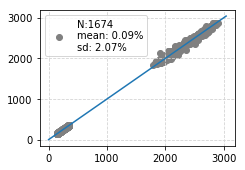

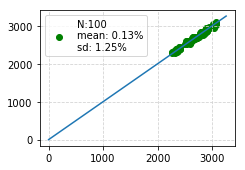

In [5]:
def myplot_aux(model, tuple_dataset, y_scaler = None):
    x = np.array([_x for _x in np.array(tuple_dataset)[:,0]])
    t = np.array([_t for _t in np.array(tuple_dataset)[:,1]])
    
    y = model(x).data
    if y_scaler is not None:
        t = y_scaler.inverse_transform(t)
        y = y_scaler.inverse_transform(y)
        #x[:,0] = y_scaler.inverse_transform(x[:,0])
        
    return t,x, y

model.predictor
y_act,x, y_pre = myplot_aux(model.predictor, train, y_scaler)
myplot(y_act, y_pre, color = 'gray')
y_act,x, y_pre = myplot_aux(model.predictor, test, y_scaler)
myplot(y_act, y_pre, color='green')

#IO_normalization前のOpen値を入力
xx=[]
xx[len(df.Open[:])-test_data_size:len(df.Open[:])] = df.Open[len(df.Open[:])
                                                             -test_data_size:len(df.Open[:])]

try:
    y_sch = df[y_columns].values
    p_sch = df[[col + 'sch' for col in y_columns]].values
    myplot(y_sch, p_sch)
except:
    pass

plt.show()

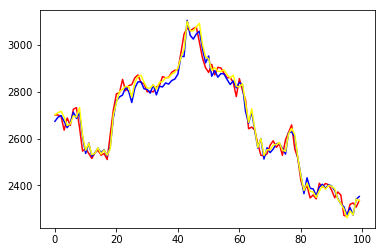

[-1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1]
0.55
[ 999910.]
[ 1000926.875]
[ 1003269.25]
[ 1009386.75]
[ 1005589.9375]
[ 1004763.4375]
[ 1007803.375]
[ 1003163.0625]
[ 1012436.375]
[ 1020021.]
[ 1018970.75]
[ 1013726.625]
[ 1015618.875]
[ 1015769.0625]
[ 1016869.375]
[ 1016237.5]
[ 1014354.875]
[ 1016490.9375]
[ 1023496.875]
[ 1021018.75]
[ 1025101.875]
[ 1025561.125]
[ 1020816.125]
[ 1022734.125]
[ 1022263.4375]
[ 1016263.]
[ 1014024.8125]
[ 1013191.125]
[ 1016384.875]
[ 1016832.125]
[ 1018422.0625]
[ 1019851.625]
[ 1023060.1875]
[ 1021877.9375]
[ 1023353.125]
[ 1020940.5]
[ 1021011.125]
[ 1020760.5]
[ 1019818.0625]
[ 1018772.5]
[ 1019473.375]
[ 1021407.8125]
[ 101

In [6]:

csvFile = open(str(num_brand)+"_result.csv",'wt',newline ='',encoding="shift_jis")
writer=csv.writer(csvFile)
writer.writerow(['num_brand=',num_brand])

a=[x for x in range(len(y_act))]

plt.plot(a,y_act,color='red')
plt.plot(a,y_pre,color='blue')
plt.plot(a,xx,color = 'yellow')

updown_y_act=[]
updown_y_pre=[]
score = 0

plt.show()

for i in range(len(xx)):
    if xx[i]<y_act[i]:
        updown_y_act.append(1)
    else:
        updown_y_act.append(-1)

    if xx[i]<y_pre[i]:
        updown_y_pre.append(1)
    else:
        updown_y_pre.append(-1)

    if updown_y_act[i] == updown_y_pre[i]:
        score = score +1
    else:
        pass

print(updown_y_pre)

score = score/len(x)
print(score)
writer.writerow(['score=',score])
writer.writerow(['stock buying and selling simulation'])


Fund = 1000000 #[円]
Investment = 0 #投資額/日
stock_num = 0 #購入株数/日
charge = 90 #手数料
ratio_inv = 0.3

#株売買ｼﾐｭﾚｰｼｮﾝ
for i in range(len(x)):
    if updown_y_pre[i] ==1:
        Investment = ratio_inv*Fund
        Fund = Fund - Investment
        stock_num = Investment/xx[i]
        Fund = Fund + stock_num*y_act[i]-charge
    if updown_y_pre[i] ==-1:
        Investment = ratio_inv*Fund
        Fund = Fund + Investment
        stock_num = Investment/xx[i]
        Fund = Fund - stock_num*y_act[i]-charge

    writer.writerow(['Day',i,Fund[0]/10000])
    print(Fund)

#結果をcsv形式で保存

csvFile.close()

In [7]:
#for i in range(2):
#    model_run()
#    show_graph()
#    stock_sim()